# Dataset Registry & Visualization using Amazong Glue Catalog & Amazon Athena

## Introduction
Datasets are generally constructed from multiple sources depending on your activity. Therefore, there is the need to structure the flow of these datasets by enabling quick registration and querying. 

In this notebook, we use **Amazon GLUE Catalog** to create databases and register the Bank Churn dataset. Then we leverage **Amazon ATHENA** to enable efficient querying and information retrieval. 

### Table of Contents

- [1. Import & Transform the raw dataset](#c1w2-1.)
  - [1.1 Copy the dataset from Amazon S3](#c1w2-1.1.)
  - [1.2 Create a pandas data frame from the CSV file](#c1w2-1.2.)
  - [1.3 Transform the dataset](#c1w2-1.3.)
  - [1.4 Write dataset to local CSV file](#c1w2-1.4.)
- [2. Register S3 Dataset as a table to enable querying](#c1w2-2.)
  - [2.1 Copy file to S3 Bucket](#c1w2-2.1.)
  - [2.2 Import AWS Data Wrangler & Create AWS Glue Data Catalog](#c1w2-2.2.)
    - [2.2.1 Create database if it does not already exist](#c1w2-2.2.1)
    - [2.2.2 Review list of available databases](#c1w2-2.2.2)
    - [2.2.3 Review list of available tables](#c1w2-2.2.3)
    - [2.2.4 Review list of available tables](#c1w2-2.2.3)
  - [2.3. Create CSV tables in the destination database](#c1w2-2.3.)
    - [2.3.1 Map columns types to match AWS Glue Catalog](#c1w2-2.3.1)
    - [2.3.2  Create CSV tables for month1 and month2 churn prediction](#c1w2-2.3.2)
    - [2.3.3 Review AWS Glue Catalog databases](#c1w2-2.3.3)
    - [2.3.4 Review list of available tables](#c1w2-2.3.4)
- [3. Perform Visualization on the registered dataset](#c1w2-3.)
  - [3.1 Create Athena Bucket for querying](#c1w2-3.1)
  - [3.2 Query the dataset and visualize columns](#c1w2-3.1)
    - [3.2.1 Retrieve customers churn table for month1](#c1w2-2.3.2.1)
    - [3.2.2 Explore correlations in retrieved dataset](#c1w2-2.3.2.2)
    - [3.2.3 Explore differences in customer patterns with respect to churn outcome](#c1w2-2.3.2.3)
    - [3.2.4 Retrieve number of churners](#c1w2-2.3.2.4)
    - [3.2.5 Retrieve number of churners according to education level](#c1w2-2.3.2.5)
    - [3.2.6 Retrieve number of churners according to customer status](#c1w2-2.3.2.6)
- [4. Conclusion & Next steps](#c1w2-4.)

# 1. Import & Transform the raw dataset

## 1.1 Copy the dataset from Amazon S3
The initial dataset is in Amazon S3, let's go ahead and copy it into the Studio Environment.

In [2]:
!aws s3 cp s3://$bucket/data/raw/BankChurners.csv ./Data Acquisition & Registry/data/BankChurners.csv


/bin/bash: line 1: Registry/data/BankChurners.csv: No such file or directory


## 1.2 Create a pandas data frame from the CSV file

Let's create and describe a Pandas dataframe starting from the available CSV file.

In [3]:
import pandas as pd


local_data_path = './data/BankChurners.csv'
data = pd.read_csv(local_data_path)

data.shape


(10127, 23)

In [4]:
data.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,1
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,1
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1


## 1.3. Transform the dataset

We perform simple operations to make the dataset more understandabble. Target column names are changed and missing values are dropped.

In [5]:
data_transformed = data.rename(columns={
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1':'churn_mon1',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2':'churn_mon2'
        })

data_transformed.dropna(inplace = True)
data_transformed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

## 1.4 Write dataset to local CSV file

Then we save the dataset in twol local files. Each file corresponds to the month where the customer churn needs to be predicted.
Since customer churn is studied across two months, the resulting datasets are the following:
- `BankChurners_month1_transformed`
- `BankChurners_month2_transformed`

In [6]:
import os


warnings.filterwarnings("ignore")

local_directory = './data/DatasetRegistration'
outname1 = 'BankChurners_month1_transformed.csv'
outname2 = 'BankChurners_month2_transformed.csv'

try:
    data_transformed.drop(columns = ['churn_mon2']).to_csv(os.path.join(local_directory, outname1), index=False)
    data_transformed.drop(columns = ['churn_mon1']).to_csv(os.path.join(local_directory, outname2), index=False)
except OSError:
    os.mkdir(local_directory)
    data_transformed.drop(columns = ['churn_mon2']).to_csv(os.path.join(local_directory, outname1), index=False)
    data_transformed.drop(columns = ['churn_mon1']).to_csv(os.path.join(local_directory, outname2), index=False)
    

# 2. Register S3 Dataset as a table to enable querying

The transformed dataset now needs to be pushed an S3 Bucket in order to enable the dataset registration. This section describes the correspondings steps. 

In [7]:
import os
import sagemaker
import logging
import boto3
import time
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## 2.1 Copy file to S3 Bucket

First, the local files are uploaded to an S3 Bucket. One file is uploaded per target month.

In [8]:
!aws s3 cp ./data/DatasetRegistration/BankChurners_month1_transformed.csv s3://$bucket/data/transformed_querying/month1/BankChurners_mon1.csv


upload: data/DatasetRegistration/BankChurners_month1_transformed.csv to s3://sagemaker-eu-west-3-668303144976/data/transformed_querying/month1/BankChurners_mon1.csv


In [9]:
!aws s3 cp ./data/DatasetRegistration/BankChurners_month2_transformed.csv s3://$bucket/data/transformed_querying/month2/BankChurners_mon2.csv


upload: data/DatasetRegistration/BankChurners_month2_transformed.csv to s3://sagemaker-eu-west-3-668303144976/data/transformed_querying/month2/BankChurners_mon2.csv


In [11]:
from IPython.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=data/transformed_querying/&showversions=false">Amazon S3 buckets</a></b>'.format(bucket, region)))

## 2.2 Import AWS Data Wrangler & Create AWS Glue Data Catalog

**AWS Data Wrangler** enables a large set of operations on the data, among which the creation of **AWS GLUE Data Catalog**. In this section, we create a new database to register the bank churn data, then we review the existing databases and the list of tables.

In [12]:
!pip install --disable-pip-version-check -q awswrangler

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.2 which is incompatible.
sagemaker 2.199.0 requires urllib3<1.27, but you have urllib3 2.0.7 which is incompatible.
spyder 5.3.3 requires ipython<8.0.0,>=7.31.1, but you have ipython 8.18.1 which is incompatible.
spyder 5.3.3 requires pylint<3.0,>=2.5.0, but you have pylint 3.0.2 which is incompatible.


### 2.2.1 Create database if it does not already exist

In [13]:
import awswrangler as wr


database_name = 'bank_churn_prediction'
wr.catalog.create_database(
        name=database_name,
        description='Database for banks customers churn prediction over two months. Each month is represented by a table.',
        exist_ok=True
)


### 2.2.2 Review list of available databases

In [14]:
wr.catalog.databases()


,Database,Description
0,bank_churn_prediction,Database for banks customers churn prediction ...
1,default,
2,sagemaker_featurestore,


### 2.2.3 Review list of available tables

In [15]:
wr.catalog.tables(database=database_name)


,Database,Table,Description,TableType,Columns,Partitions
0,bank_churn_prediction,bank_churn_month1,,EXTERNAL_TABLE,"clientnum, attrition_flag, customer_age, gende...",
1,bank_churn_prediction,bank_churn_month2,,EXTERNAL_TABLE,"clientnum, attrition_flag, customer_age, gende...",


## 2.3 Create CSV tables in the destination database

### 2.3.1 Map columns types to match AWS Glue Catalog

**AWS Glue Catalog** has a specific data model. Therefore, we need to map the column types from pandas. 

In [16]:
# Create dataframe and retrieve columns types

data_mon1 = data_transformed.drop(columns = ['churn_mon2'])
data_types = pd.DataFrame(data_mon1.dtypes.to_dict(), 
                              index = [0]).replace({'int64': 'int',
                                                    'object':'string',
                                                    'float64': 'float'}).T.to_dict()[0]


### 2.3.2 Create CSV tables for `month1` and `month2` churn prediction

In [17]:
# Create CSV table for churn month1

wr.catalog.create_csv_table(
        database=database_name,
        table='bank-churn-month1',
        path='s3://{}/data/transformed_querying/month1/'.format(bucket),
        columns_types=data_types,
        skip_header_line_count=1
)


In [18]:
# Create CSV table for churn month 2

data_mon2 = data_transformed.drop(columns = ['churn_mon1'])
wr.catalog.create_csv_table(
        database=database_name,
        table='bank-churn-month2',
        path='s3://{}/data/transformed_querying/month2/'.format(bucket),
        columns_types=data_types,
        skip_header_line_count=1
)


### 2.3.3 Review **AWS Glue Catalog** databases

In [19]:
from IPython.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://eu-west-3.console.aws.amazon.com/glue/home?region={}#/v2/data-catalog/databases">AWS Glue Catalog databases</a></b>'.format(region)))

# 3. Perform Visualization on the registered dataset
Once the dataset is registered, it is available for querying and visualization. This section is about performing some `SQL` querying and visualization on top of it.

## 3.1 Create Athena Bucket for querying

In [20]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


database_name = 'bank_churn_prediction'
athena_table_name = 'bank_churn_month1'

In [21]:
wr.athena.create_athena_bucket()

's3://aws-athena-query-results-668303144976-eu-west-3/'

## 3.2 Query the dataset and visualize columns

### 3.2.1 Retrieve customers churn table for month1
The table is ordered by `customer ID` in this example.

In [22]:
statement_table = '''
SELECT * 
FROM {}
ORDER BY clientnum
'''.format(athena_table_name)


print(statement_table)


SELECT * 
FROM bank_churn_month1
ORDER BY clientnum



In [23]:
df_churn = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_churn

/opt/conda/lib/python3.10/site-packages/awswrangler/_distributed.py:104: FutureWarning: promote has been superseded by mode='default'.
  return cls.dispatch_func(func)(*args, **kw)


,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn_mon1
0,708082083,Existing Customer,45,F,3,High School,Married,Less than $40K,Blue,36,...,3,3544.000000,1661,1883.000000,0.831,15149,111,0.734,0.469,0
1,708083283,Attrited Customer,58,M,0,Unknown,Single,$40K - $60K,Blue,45,...,3,3421.000000,2517,904.000000,0.992,992,21,0.400,0.736,1
2,708084558,Attrited Customer,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,...,3,8258.000000,1771,6487.000000,0.000,1447,23,0.000,0.214,1
3,708085458,Existing Customer,34,F,2,Uneducated,Single,Less than $40K,Blue,24,...,2,1438.300049,0,1438.300049,0.827,3940,82,0.952,0.000,0
4,708086958,Existing Customer,49,F,2,Uneducated,Married,Unknown,Blue,41,...,2,3128.000000,749,2379.000000,0.598,4369,59,0.735,0.239,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,828288333,Existing Customer,50,M,0,Uneducated,Married,$60K - $80K,Blue,46,...,3,3640.000000,659,2981.000000,0.938,3756,70,0.842,0.181,0
10123,828291858,Attrited Customer,38,M,3,College,Single,$60K - $80K,Blue,34,...,4,12050.000000,1821,10229.000000,0.630,2381,40,0.481,0.151,1
10124,828294933,Attrited Customer,49,F,3,High School,Married,Less than $40K,Blue,45,...,3,2951.000000,2437,514.000000,0.765,2519,36,0.565,0.826,1
10125,828298908,Existing Customer,54,M,4,Graduate,Married,$120K +,Blue,50,...,0,2872.000000,2035,837.000000,0.613,1770,47,0.741,0.709,0


### 3.2.2 Explore correlations in retrieved dataset
The columns seem to be quite correlated with the customers' churn. This may indicate a good learning base for the model. 

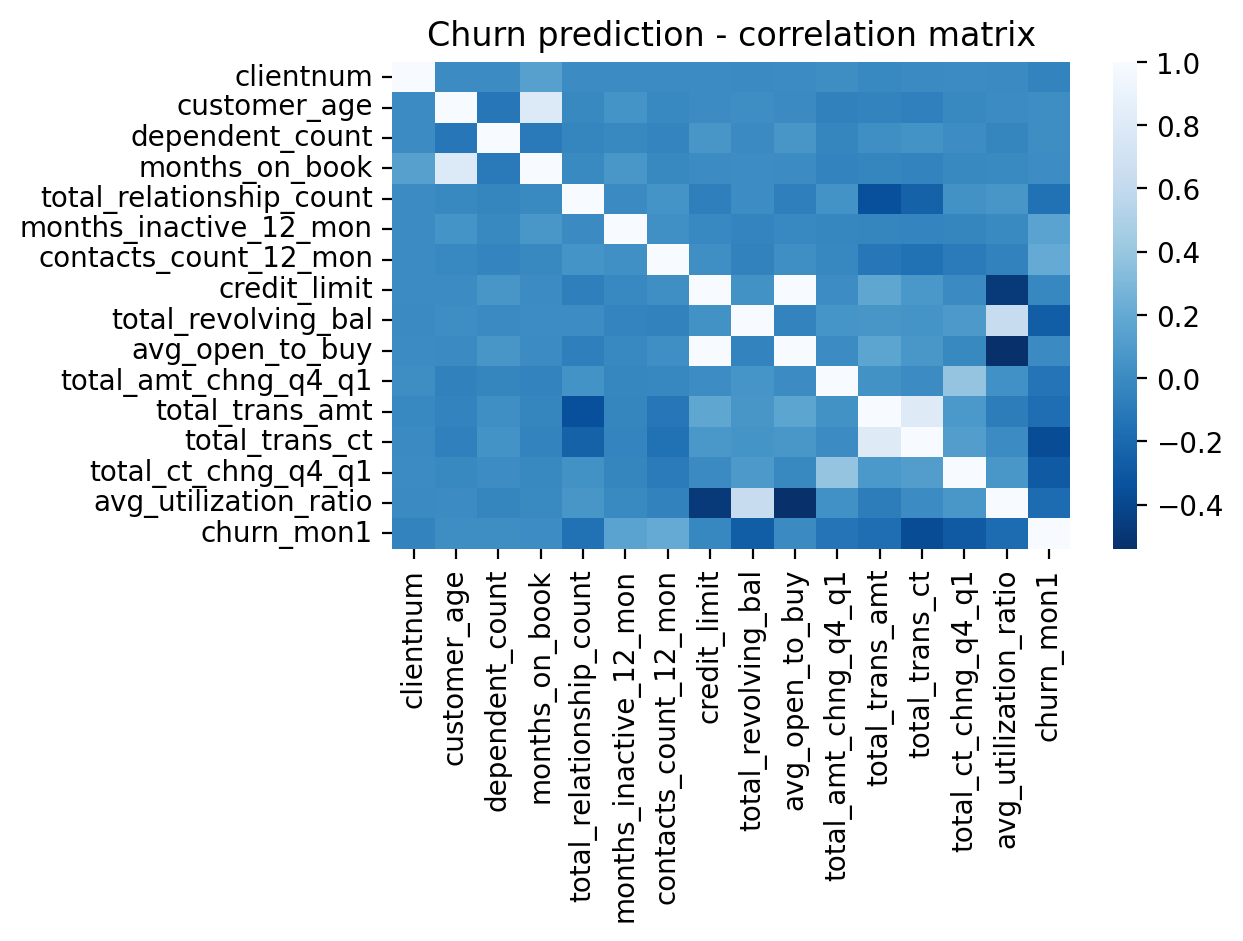

In [25]:
sns.heatmap(df_churn.select_dtypes(['float', 'int']).corr(), cmap = 'Blues_r')
plt.title('Churn prediction - correlation matrix')
plt.tight_layout();


### 3.2.3 Explore differences in customer patterns with respect to churn outcome
Customers who churn seem to be more concentrated around low values of `Total Amount of change between Q1 and Q4.`

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


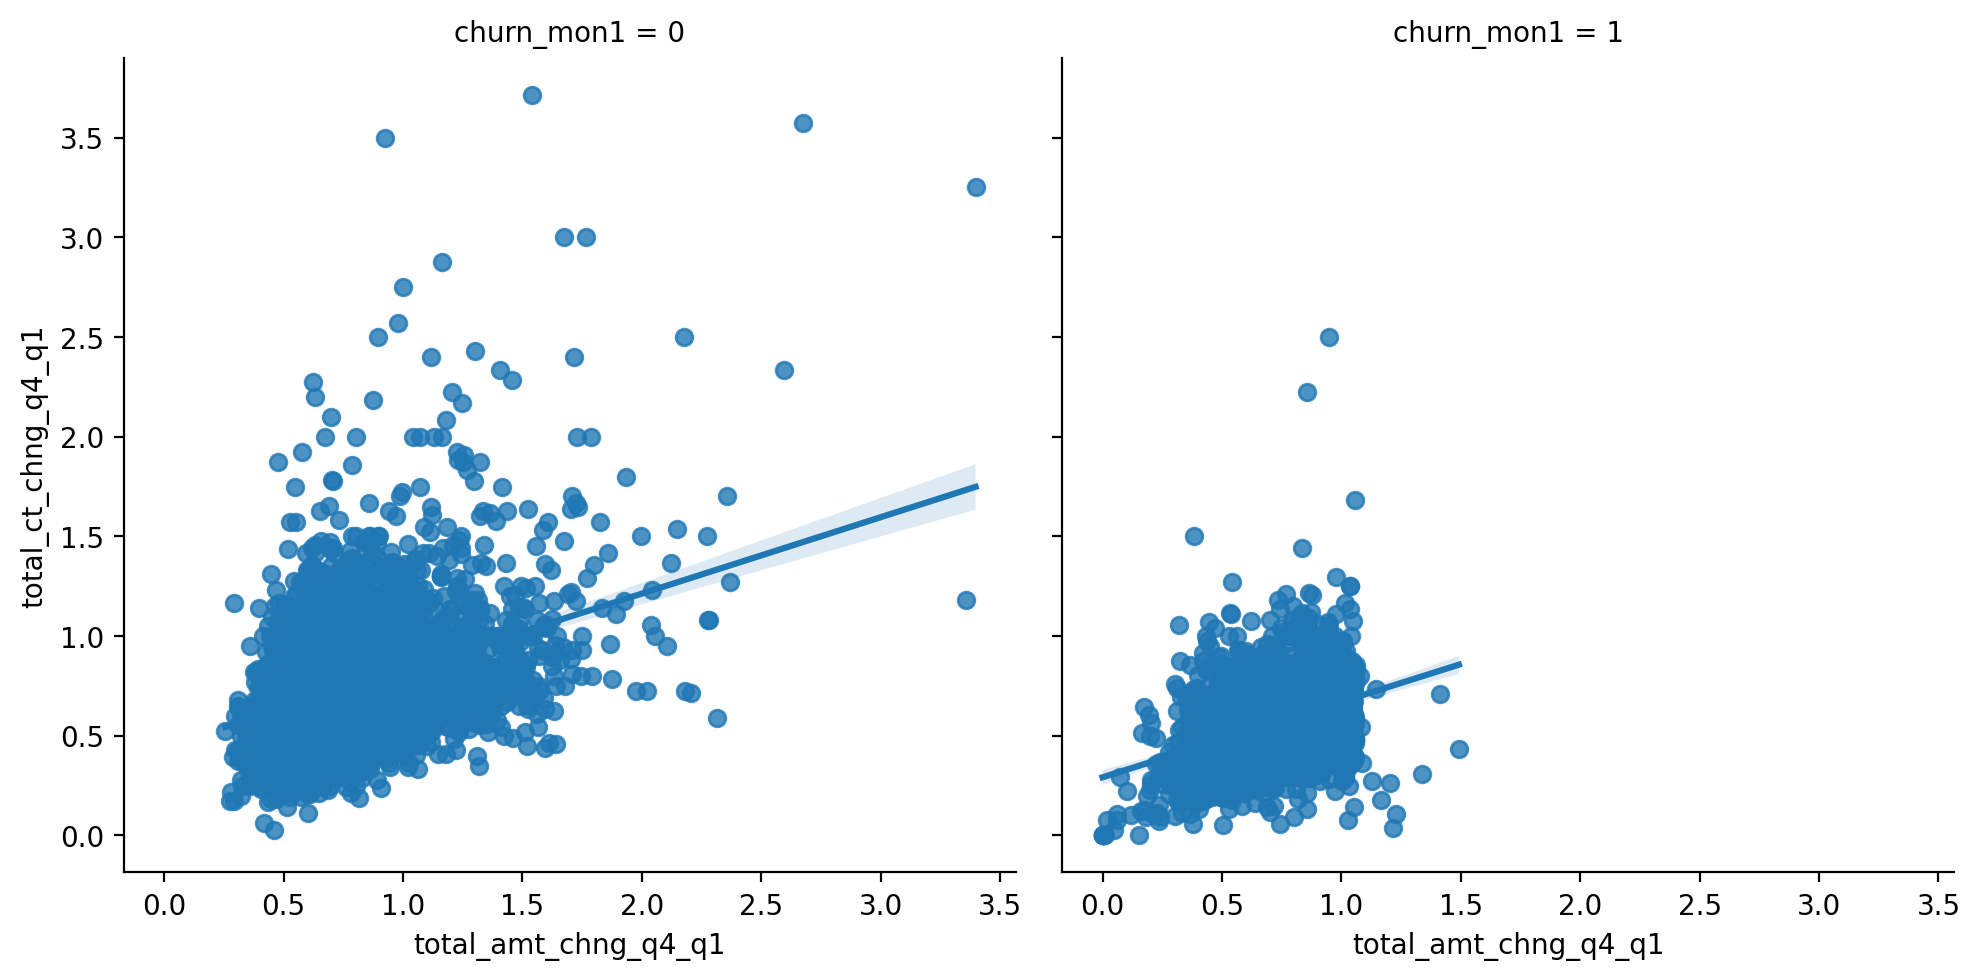

In [28]:
sns.lmplot(x="total_amt_chng_q4_q1", y="total_ct_chng_q4_q1", col="churn_mon1", data=df_churn);
plt.tight_layout();


### 3.2.4 Retrieve number of churners

In [29]:
statement_table = '''
SELECT churn_mon1, COUNT(churn_mon1) as nb_churners
FROM {}
GROUP BY churn_mon1
'''.format(athena_table_name)


print(statement_table)


SELECT churn_mon1, COUNT(churn_mon1) as nb_churners
FROM bank_churn_month1
GROUP BY churn_mon1



In [30]:
df_count_churners = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_count_churners

/opt/conda/lib/python3.10/site-packages/awswrangler/_distributed.py:104: FutureWarning: promote has been superseded by mode='default'.
  return cls.dispatch_func(func)(*args, **kw)


,churn_mon1,nb_churners
0,1,1627
1,0,8500


The total number of non-churners is way higher than the churners'. This indicates imbalance in the dataset, that will be dealt with in the next labs, with the aim to build models for churn prediction.

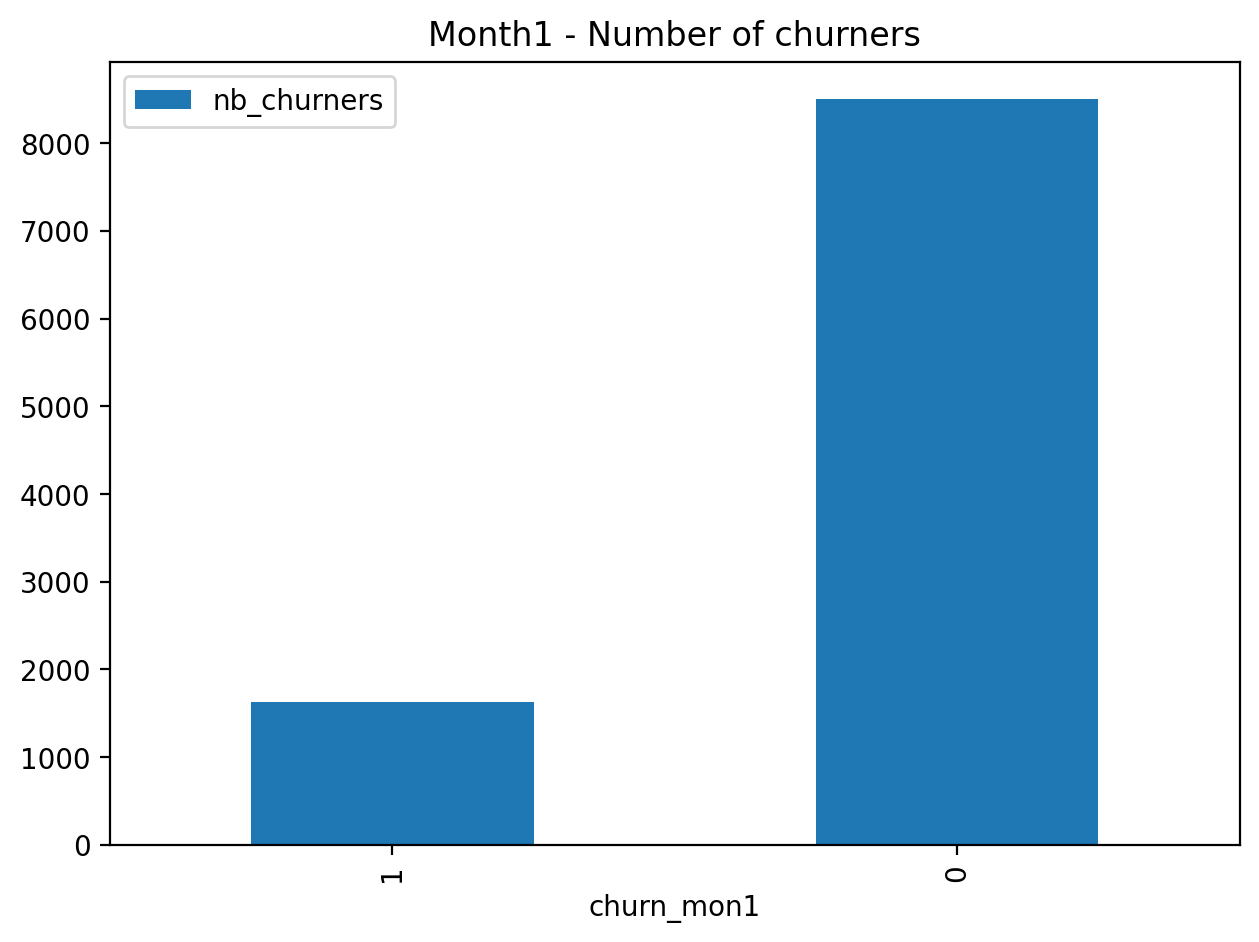

In [31]:
df_count_churners.plot(x='churn_mon1', kind='bar', title='Month1 - Number of churners')
plt.tight_layout();


### 3.2.5  Retrieve number of churners according to education level

In [32]:
statement_table = '''
SELECT education_level, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM {}
GROUP BY education_level, churn_mon1
ORDER BY education_level
'''.format(athena_table_name)


print(statement_table)


SELECT education_level, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM bank_churn_month1
GROUP BY education_level, churn_mon1
ORDER BY education_level



In [33]:
df_count_churners = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_count_churners

/opt/conda/lib/python3.10/site-packages/awswrangler/_distributed.py:104: FutureWarning: promote has been superseded by mode='default'.
  return cls.dispatch_func(func)(*args, **kw)


,education_level,churn_mon1,nb_churners
0,College,0,859
1,College,1,154
2,Doctorate,1,95
3,Doctorate,0,356
4,Graduate,0,2641
5,Graduate,1,487
6,High School,0,1707
7,High School,1,306
8,Post-Graduate,1,92
9,Post-Graduate,0,424


In addition to class imbalance, the dataset also presents an imbalance in the customers' categories. Interesting to notice that graduates are customers who churn the most. Churn/non-churn ratio seems to be steady cross categories.

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


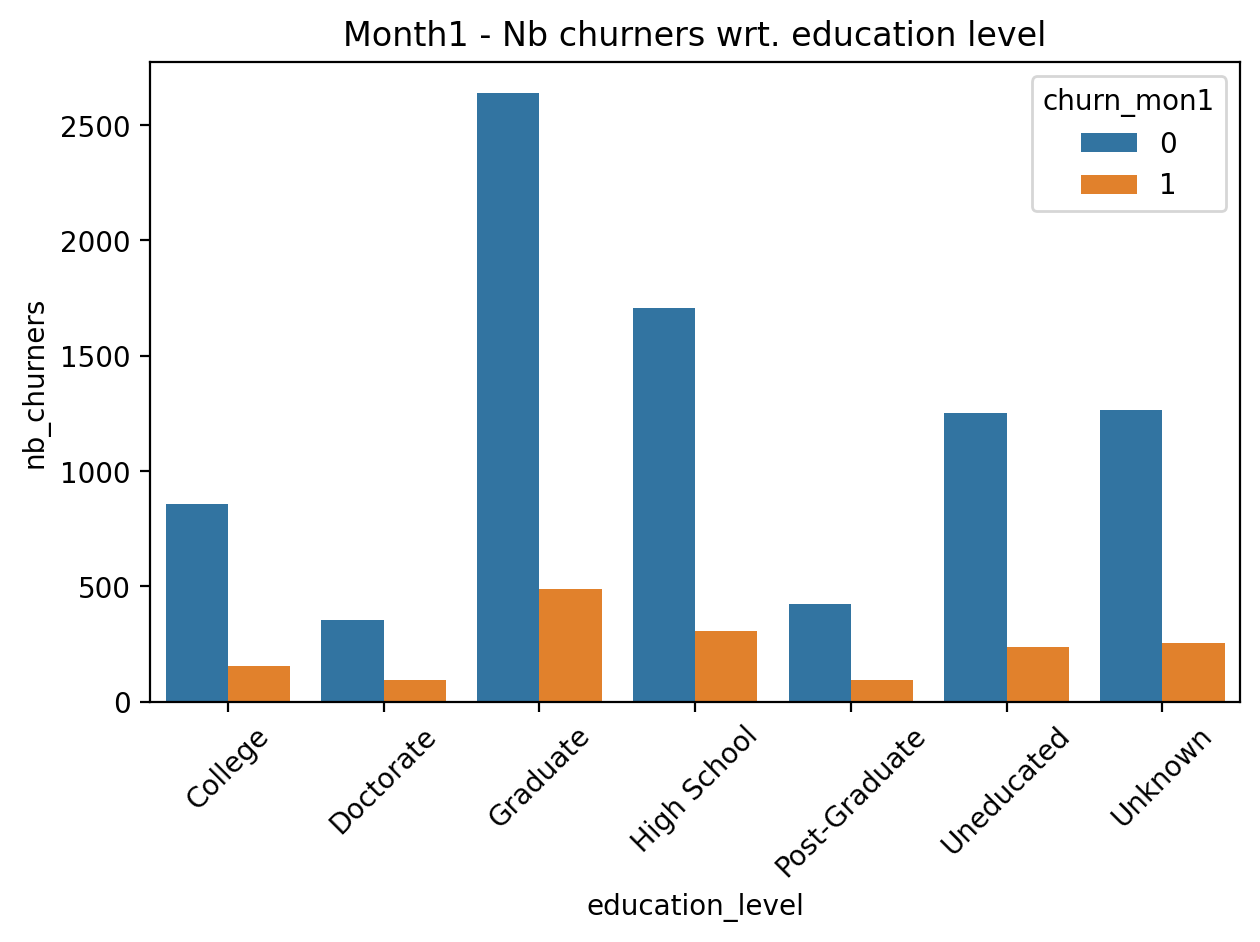

In [34]:
sns.barplot(data=df_count_churners, x ='education_level', y='nb_churners', hue='churn_mon1')
plt.title('Month1 - Nb churners wrt. education level')
plt.xticks(rotation=45)
plt.tight_layout();


### 3.2.6 Retrieve number of churners according to customer status

In [35]:
statement_table = '''
SELECT Attrition_Flag, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM {}
GROUP BY Attrition_Flag, churn_mon1
ORDER BY Attrition_Flag
'''.format(athena_table_name)


print(statement_table)


SELECT Attrition_Flag, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM bank_churn_month1
GROUP BY Attrition_Flag, churn_mon1
ORDER BY Attrition_Flag



In [36]:
df_count_churners = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_count_churners

/opt/conda/lib/python3.10/site-packages/awswrangler/_distributed.py:104: FutureWarning: promote has been superseded by mode='default'.
  return cls.dispatch_func(func)(*args, **kw)


,attrition_flag,churn_mon1,nb_churners
0,Attrited Customer,1,1627
1,Existing Customer,0,8500


Attrited customers seem to have the higher churn rate. New customers tend not to churn aftern 1 month.

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


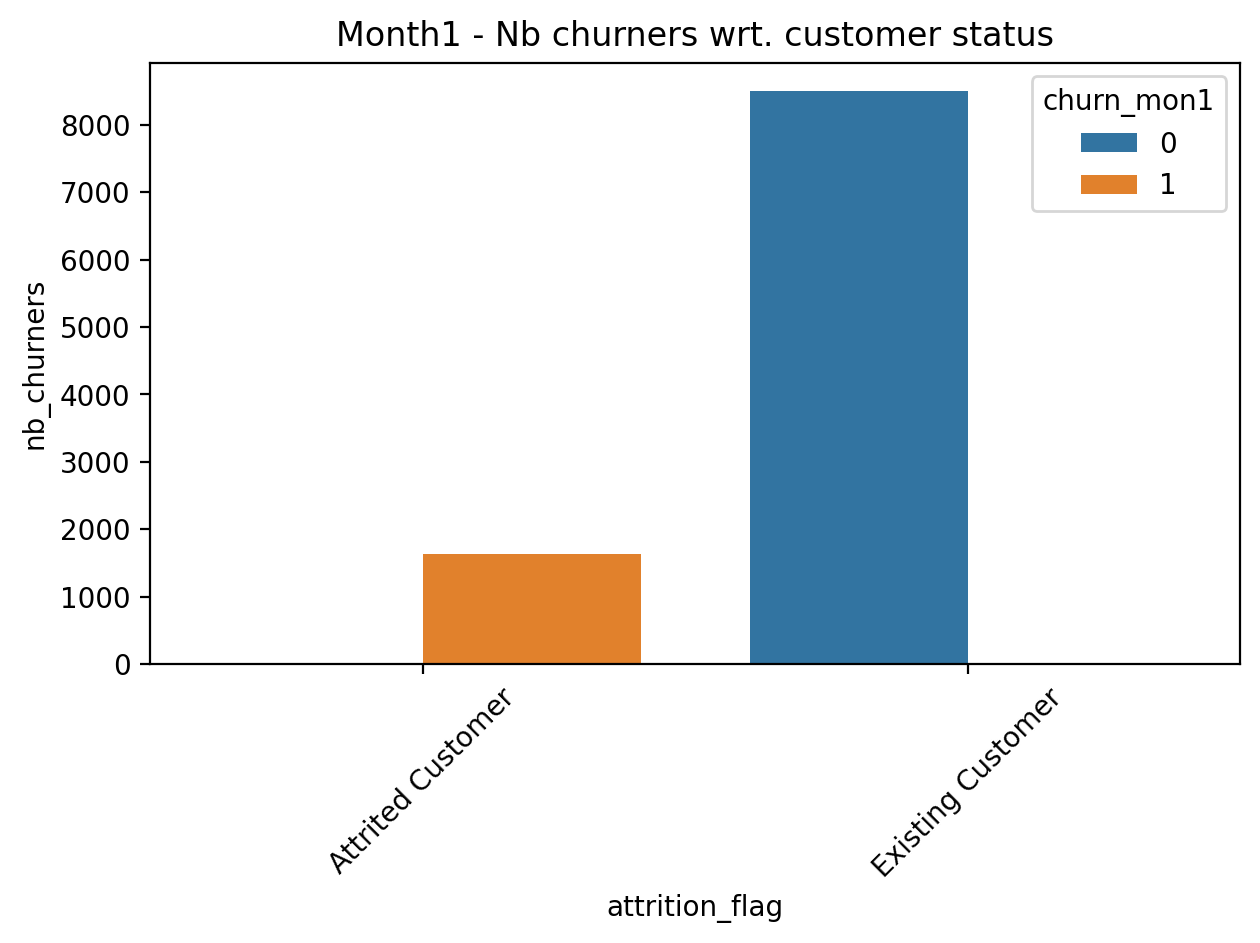

In [37]:
sns.barplot(data=df_count_churners, x ='attrition_flag', y='nb_churners', hue='churn_mon1')
plt.title('Month1 - Nb churners wrt. customer status')
plt.xticks(rotation=45)
plt.tight_layout();


# 4. Conclusion & next steps
In this notebook, we went through dataset registry and querying in order to prepare for data visualization. **Amazon Glue Data Catalog** was used to create a database and to register the dataset, then querying has been perormed using **Amazon Athena**. 

As a result, some patterns have been discovered in the dataset, such as class imbalance and some correlations between customers churn and their available information.

As a next step, we explore the data bias and make operations on the dataset in order to prepare the data for machine learning.